# Link Prediction

In [ ]:
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
sns.set(style='darkgrid')

In [ ]:
# Load data

edge_df = pd.read_csv("data/edges.csv", delimiter=",")
node_df = pd.read_csv("data/nodes.csv", delimiter=",")


In [ ]:
# Turn into networkx graph

G = nx.from_pandas_edgelist(edge_df, source="# source", target=" target", create_using=nx.Graph())

#nx.number_of_edges(G)

nx.number_of_nodes(G)


5242

In [ ]:
largest_cc = max(nx.connected_components(G), key=len)
LG = G.subgraph(largest_cc)

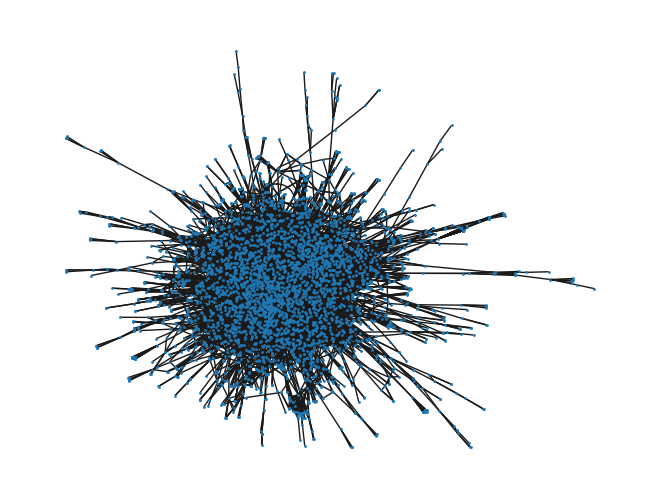

In [ ]:
nx.draw(LG, node_size=1)

### Preferential Attachment

In [ ]:
#%%script echo Skipping!
# We define a function called pref_attachment
def pref_attachment(graph, n):
    scores = []
    track = [] # a list to keep track of all the nodes and their score for later use
    # We use the preferential attachment documentation from networkx
    linkpred_pa = list(nx.preferential_attachment(graph))
    # Now we sort in decreasing score
    linkpred_pa.sort(key = lambda tup: tup[2], reverse = True)
    # We make a for-loop for the link predictions between the nodes
    for u, v, p in linkpred_pa[:n]:
        # We normalize the scores using the G.number_of_nodes
        score = p * (1 / (2 * graph.number_of_nodes()))
        scores.append(score)
        print(f"({u}, {v}) -> {score:.3f}")
        track.append(((u,v), score)) # append the nodes as tuple and score as float

    plt.title("Preferential attachment")
    plt.xlabel("Score")
    plt.ylabel("Number of nodes")
    plt.hist(scores, bins=50)
    plt.show()
    return scores, track
    
# We run the function and save the list of scores
#scores, track = pref_attachment(LG, LG.number_of_nodes())

The result we get is the score of possible edges between nodes that don't have that specific edge between them. SO the bigger the degree of a certain node is, the higher the possibility of an edge appearing between those two nodes. 

In [ ]:
track

[((21012, 15244), 0.5746753246753247),
 ((21281, 15244), 0.5604858104858105),
 ((12365, 15244), 0.5462962962962963),
 ((22691, 15244), 0.5462962962962963),
 ((9785, 15244), 0.48244348244348245),
 ((6610, 15244), 0.48244348244348245),
 ((21012, 6512), 0.4772727272727273),
 ((21508, 15244), 0.47534872534872535),
 ((17655, 15244), 0.46825396825396826),
 ((21281, 6512), 0.4654882154882155),
 ((2741, 15244), 0.46115921115921116),
 ((12365, 6512), 0.4537037037037037),
 ((22691, 6512), 0.4537037037037037),
 ((19423, 15244), 0.44696969696969696),
 ((15003, 15244), 0.4398749398749399),
 ((21012, 13801), 0.4383116883116883),
 ((21012, 13929), 0.4383116883116883),
 ((21281, 13801), 0.42748917748917753),
 ((21281, 13929), 0.42748917748917753),
 ((14807, 15244), 0.4256854256854257),
 ((10350, 21012), 0.41883116883116883),
 ((18866, 21281), 0.417989417989418),
 ((12365, 13801), 0.4166666666666667),
 ((12365, 13929), 0.4166666666666667),
 ((4511, 22691), 0.4166666666666667),
 ((13801, 22691), 0.41666

In [ ]:
# Looking at the highest probability, aka the first element in the list

# see if it adds up

node_u = track[0][0][0] # the first node (u). 21012, degree 81
node_v = track[0][0][1] # the second node (v).   15244

node_list_degrees = pd.read_csv("data/node_list_degrees.csv")

u_idx = np.where(node_list_degrees["Node_id"]==node_u)
v_idx = np.where(node_list_degrees["Node_id"]==node_v)

v_idx = v_idx[0][0]
u_idx = u_idx[0][0]

# the degrees of node u and v
u_degree = node_list_degrees['Degree'][u_idx]
v_degree = node_list_degrees['Degree'][v_idx]

# PA(x,y) = |N(x)| * |N(y)| where N(u) is the set of nodes adjacent to u.
# so x's degree * y's degree * (1/num nodes)  to normalise

u_degree * v_degree * (1/(2*len(LG.nodes)))




0.5746753246753247

So, the highest score in the Preferential Attachment, is node 21012 and node 15244. They have a probability of 0.5746 of connecting if a random edge was added in the graph.

Their degree is: node 21012: degree  81 ------ node 15244: degree: 59

### Adamic Adar

In [ ]:
%%script echo Skipping!
ef adamic_adar(graph, top_n):
    scores = []
    linkpred_aa = list(nx.adamic_adar_index(graph))
    # Sort in decreasing score
    linkpred_aa.sort(key = lambda tup: tup[2], reverse = True)
    for u, v, p in linkpred_aa[:top_n]:
        scores.append(p)
        print(f"({u}, {v}) -> {p:.8f}")


    plt.title("Adamic-Adar", loc = 'left')
    plt.xlabel("Score")
    plt.ylabel("Number of nodes")
    plt.hist(scores, bins=50)
    plt.show()

adamic_adar(G, G.number_of_nodes())

Skipping!


In Adamic-Adar (AA) we say that common neighbors are important, but the hubs contribute less to the link prediction than two common neighbors with no other links, because the hubs do not have enough bandwidth to make the introduction
The formula says that, for each common neighbor, instead of counting one – as we do in Common Neighbor when we look at the intersection –, we count one over the common neighbor’s degree (log-transformed).

In [ ]:
class link_pred:
    def __init__(self, graph, formula: "pref", n: int, plot= False, save = False):
        self._graph = graph
        self._scores = []
        self._link_score = []
        self._form = formula.lower()
        self._top_n = n
        self._plot = plot
        self._save = save

        if self._form == "adamic":
            self._adamic_adar()
        else:
            self._pref_attachment()


    def _adamic_adar(self):
        linkpred_aa = list(nx.adamic_adar_index(self._graph))
        # Sort in decreasing score
        linkpred_aa.sort(key = lambda tup: tup[2], reverse = True)
        for u, v, p in linkpred_aa[:self._top_n]:
            self._scores.append(p)
            self._link_score.append((u,v,p))

        if self._plot:
            self._histogram()
     
        return self._link_score

    def _pref_attachment(self):
        # We use the preferential attachment documentation from networkx
        linkpred_pa = list(nx.preferential_attachment(self._graph))
        # Now we sort in decreasing score
        linkpred_pa.sort(key = lambda tup: tup[2], reverse = True)
        # We make a for-loop for the link predictions between the nodes
        for u, v, p in linkpred_pa[:self._top_n]:
            # We normalize the scores using the G.number_of_nodes
            score = p * (1 / (2 * self._graph.number_of_nodes()))
            self._link_score.append((u,v,score))
            self._scores.append(score)
        if self._plot:
            self._histogram()

        return self._link_score
    
    def _histogram(self):
        if self._form == "adamic":
            plt.title("Adamic-Adar")
        elif self._form == "pref":
            plt.title("Preferential attachment")
        plt.xlabel("Score")
        plt.ylabel("Number of nodes")
        plt.hist(self._scores, 50)
        plt.show()
        if self._save:
            plt.savefig(f"figures/{self._form.lower()}histogram.png")
            print(f"Saved to: figures/{self._form.lower()}histogram.png !")

    def show(self):
        return self._link_score
    
    def __str__(self):
        s = ""
        for u, v, p in self._link_score:
            s += f"({u}, {v}) -> {p:.8f}\n"
        return s

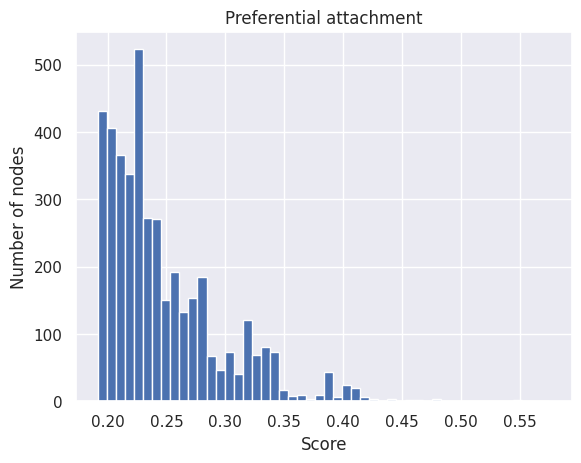

In [ ]:
link_pred(graph = LG, formula = "pref", n = LG.number_of_nodes(), plot = True)

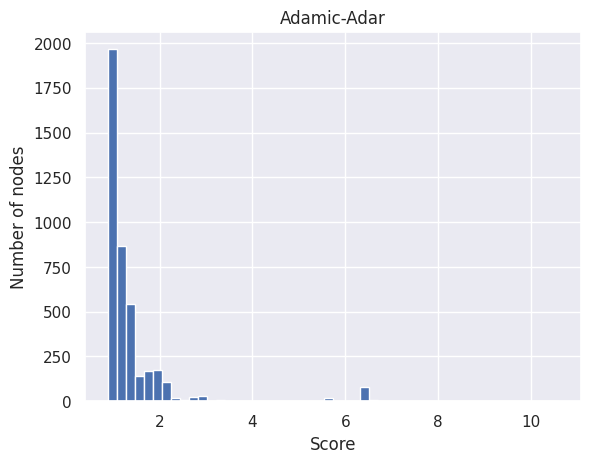

In [ ]:
link_pred(graph = LG, formula = "adamic", n = LG.number_of_nodes(), plot = True)

In [ ]:
link_pred(graph = Astro, formula = "pref", n = Astro.number_of_nodes())

NameError: name 'link_pred' is not defined


In Adamic-Adar (AA) we say that common neighbors are important, but the hubs contribute less to the link prediction than two common neighbors with no other links, because the hubs do not have enough bandwidth to make the introduction
The formula says that, for each common neighbor, instead of counting one – as we do in Common Neighbor when we look at the intersection –, we count one over the common neighbor’s degree (log-transformed).

In [ ]:
# from main
%%script echo Skipping!
def adamic_adar(graph, top_n):
    linkpred_aa = list(nx.adamic_adar_index(graph))
    # Sort in decreasing score
    linkpred_aa.sort(key = lambda tup: tup[2], reverse = True)
    for u, v, p in linkpred_aa[:top_n]:
        print(f"({u}, {v}) -> {p:.8f}")

    plt.hist(p, bins=50)
    plt.show()

adamic_adar(G, 5)

# Link-Prediction Comparisons

In [ ]:
# load the data 
Astro_edge_df = pd.read_csv("other_datasets/AstroPh/edges.csv", delimiter=",")
Astro_node_df = pd.read_csv("other_datasets/AstroPh/nodes.csv", delimiter=",")

# load the data 
Cond_edge_df = pd.read_csv("other_datasets/CondMat/edges.csv", delimiter=",")
Cond_node_df = pd.read_csv("other_datasets/CondMat/nodes.csv", delimiter=",")

# load the data 
HPH_edge_df = pd.read_csv("other_datasets/HepPh/edges.csv", delimiter=",")
HPH_node_df = pd.read_csv("other_datasets/HepPh/nodes.csv", delimiter=",")

# load the data 
HTH_edge_df = pd.read_csv("other_datasets/HepTh/edges.csv", delimiter=",")
HTH_node_df = pd.read_csv("other_datasets/HepTh/nodes.csv", delimiter=",")



# generate graphs
G1 = nx.from_pandas_edgelist(Astro_edge_df, source="# source", target=" target", create_using=nx.Graph())
G2 = nx.from_pandas_edgelist(Cond_edge_df, source="# source", target=" target", create_using=nx.Graph())
G3 = nx.from_pandas_edgelist(HPH_edge_df, source="# source", target=" target", create_using=nx.Graph())
G4 = nx.from_pandas_edgelist(HTH_edge_df, source="# source", target=" target", create_using=nx.Graph())

# only focus on the giant hub in the middle
largest_cc1 = max(nx.connected_components(G1), key=len)
largest_cc2 = max(nx.connected_components(G2), key=len)
largest_cc3 = max(nx.connected_components(G3), key=len)
largest_cc4 = max(nx.connected_components(G4), key=len)

# generate smaller graph
Astro = G1.subgraph(largest_cc1)
Cond = G2.subgraph(largest_cc2)
HPh = G3.subgraph(largest_cc3)
HTh = G4.subgraph(largest_cc4)



**AstroPh:**

Astro-Physics. 

Number of nodes: 17.903

Number of edges: 197.031

**CondMat:**

Condensed Matter. 

Number of nodes: 21.363

Number of edges: 91.342

**HepPh:**

High Energy Physics Phenomenology. 

Number of nodes: 11.204

Number of edges: 117.649

**HepTh:**

High Energy Physics Theory. 

Number of nodes: 8638

Number of edges: 24.827

## Preferential Attachment Comparison

### AstroPhysics

In [ ]:
#link_pred(graph = Astro, formula = "pref", n = Astro.number_of_nodes(), plot = True)

### Condensed Matter

In [ ]:
#link_pred(graph = Cond, formula = "pref", n = Cond.number_of_nodes(), plot = True)

### High Energy Physics Phenomenology

In [ ]:
#link_pred(graph = HPh, formula = "pref", n = HPh.number_of_nodes(), plot = True)

### High Energy Physics Theory

In [ ]:
#link_pred(graph = HTh, formula = "pref", n = HTh.number_of_nodes(), plot = True)

(14726, 26122) -> 0.068
(14726, 26398) -> 0.068
(14726, 47542) -> 0.068
(14726, 15618) -> 0.068
(47542, 54915) -> 0.068
(47542, 55319) -> 0.068
(47542, 59471) -> 0.068
(47542, 63697) -> 0.068
(47542, 65168) -> 0.068
(15618, 54915) -> 0.068
(15618, 55319) -> 0.068
(15618, 59471) -> 0.068
(15618, 63697) -> 0.068
(15618, 65168) -> 0.068
(18433, 59471) -> 0.068
(18433, 54915) -> 0.068
(18433, 55319) -> 0.068
(18433, 63697) -> 0.068
(18433, 65168) -> 0.068
(51294, 59471) -> 0.068
(51294, 54915) -> 0.068
(51294, 55319) -> 0.068
(51294, 63697) -> 0.068
(51294, 65168) -> 0.068
(51840, 59471) -> 0.068
(51840, 54915) -> 0.068
(51840, 55319) -> 0.068
(51840, 63697) -> 0.068
(51840, 65168) -> 0.068
(19470, 59471) -> 0.068
(19470, 54915) -> 0.068
(19470, 55319) -> 0.068
(19470, 63697) -> 0.068
(19470, 65168) -> 0.068
(53450, 59471) -> 0.068
(53450, 54915) -> 0.068
(53450, 55319) -> 0.068
(53450, 63697) -> 0.068
(53450, 65168) -> 0.068
(21669, 59471) -> 0.068
(21669, 54915) -> 0.068
(21669, 55319) -

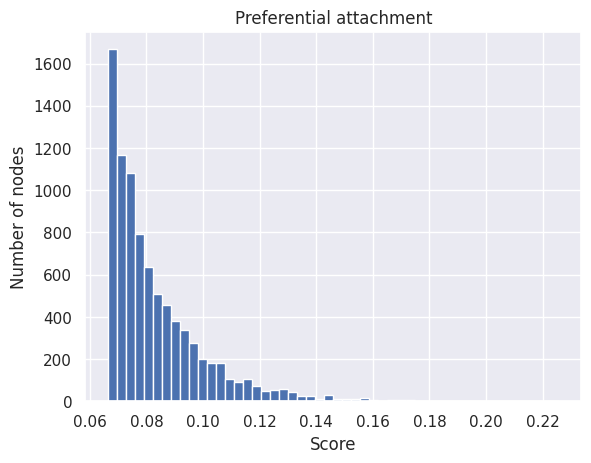

In [ ]:
scores, track = pref_attachment(HTh, HTh.number_of_nodes())

In [ ]:
from networkx.generators import barabasi_albert_graph

n = G.number_of_nodes()
m = 3

PFLG = barabasi_albert_graph(n=n,m=m)
print("edges",PFLG.number_of_edges(),"nodes", PFLG.number_of_nodes())

edges 15717 nodes 5242


In [ ]:
from networkx import google_matrix

matrix_adj=google_matrix(LG)

/tmp/ipykernel_1417/3520092421.py:3: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  matrix_adj=google_matrix(LG)


In [ ]:
matrix_adj.shape

(4158, 4158)

In [ ]:
#N = 5242 # number of nodes
P = matrix_adj # your "matrix of probabilities"
adjacency = np.random.rand(*P.shape) <= P # adjacency[ii, jj] is True with probability P[ii, jj]
graph2 = nx.from_numpy_matrix(adjacency, nx.Graph)

In [ ]:
matrix_adj

matrix([[3.60750361e-05, 1.41702742e-01, 1.41702742e-01, ...,
         3.60750361e-05, 3.60750361e-05, 3.60750361e-05],
        [2.12536075e-01, 3.60750361e-05, 2.12536075e-01, ...,
         3.60750361e-05, 3.60750361e-05, 3.60750361e-05],
        [2.83369408e-01, 2.83369408e-01, 3.60750361e-05, ...,
         3.60750361e-05, 3.60750361e-05, 3.60750361e-05],
        ...,
        [3.60750361e-05, 3.60750361e-05, 3.60750361e-05, ...,
         3.60750361e-05, 3.60750361e-05, 3.60750361e-05],
        [3.60750361e-05, 3.60750361e-05, 3.60750361e-05, ...,
         3.60750361e-05, 3.60750361e-05, 3.60750361e-05],
        [3.60750361e-05, 3.60750361e-05, 3.60750361e-05, ...,
         3.60750361e-05, 3.60750361e-05, 3.60750361e-05]])

In [ ]:
graph2.number_of_edges()


3801

In [ ]:
 LG.number_of_edges()

13428

In [ ]:
G.number_of_nodes()

4158